In [1]:
# MO444-A 2s/2017 - Second assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

from __future__ import print_function
from datetime import datetime
from math import sqrt
from scipy import misc
from skimage.io import imread
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from numpy.linalg import norm
import tensorflow as tf
import glob
import random
import matplotlib.pyplot as plt
import numpy as np

# Some definitions
classes = np.asarray(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
int_classes = preprocessing.LabelEncoder().fit_transform(classes) # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
onehot_classes = onehot_encoder.fit_transform(int_classes.reshape(len(int_classes), 1))

def load_image_dataset(name, sample=1., as_gray=False):
    """Loads an image dataset
    name: directory in which dataset is defined
    sample: fraction of the dataset to be loaded [0, 1]
    as_gray: read images as grayscale to have a 32x32 matrix, instead of a 32x32x3 matrix in case of RGB.
    """
    random.seed(1)
    X, Y = [], []
    with open('cifar-10/%s/labels' % name) as labels:
        i = 0
        for path in sorted(glob.glob('cifar-10/%s/*.png' % name)):
            y = int(labels.next())
            if random.random() > sample:
                continue
            Y.append(y)
            X.append(imread(path, as_grey=as_gray))
    X, Y = np.array(X), np.array(Y)
    n_dim = reduce(lambda x, y: x * y, X.shape[1:])
    return X.reshape(-1, n_dim), Y

def display_image(x):
    """Prints a colored or grayscale 32x32 image"""
    colors = x.shape[0] / 32 / 32
    cmap = 'gray' if colors == 1 else 'jet'
    new_shape = (32, 32) if colors == 1 else (32, 32, colors)
    plt.imshow(x.reshape(new_shape), cmap=cmap)
    plt.show()

In [2]:
# Load train dataset
data_X, data_Y = load_image_dataset('train', as_gray=True, sample=0.1)
print("Loaded %d samples" % len(data_X))

Loaded 5053 samples


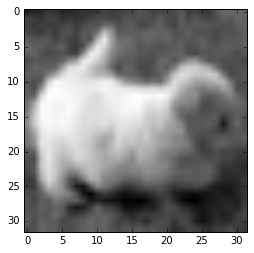

Label: dog


In [3]:
# Take a look at a sample and its class
display_image(data_X[207])

print('Label: %s' % classes[int(data_Y[207])])

In [4]:
# Implementing K-Fold to help avoiding overfitting
from sklearn.model_selection import KFold

def print_results(k, start_time, train_precision, train_recall, train_f1, 
                  validation_precision, validation_recall, validation_f1):
    print('\nk={} time elapsed: {}'.format(k, datetime.now() - start_time))
    print('           Precision  sd      Recall sd     F1 Score sd')
    print('Training:      %5.2f  ±%5.2f   %5.2f ±%5.2f    %5.2f ±%5.2f' % (
            np.mean(train_precision), np.std(train_precision), np.mean(train_recall), np.std(train_recall), np.mean(train_f1), np.std(train_f1)))
    print('Validation:    %5.2f  ±%5.2f   %5.2f ±%5.2f    %5.2f ±%5.2f' % (
            np.mean(validation_precision), np.std(validation_precision), np.mean(validation_recall), np.std(validation_recall), np.mean(validation_f1), np.std(validation_f1)))

def run_kfold(method, data_Y, data_X, scale=False, check_gradients=False, report_timeout_seconds=60):
    # prepare for 5-fold execution
    random_state = np.random.RandomState(1)
    k5_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    train_precision, train_recall, train_f1 = [], [], []
    validation_precision, validation_recall, validation_f1 = [], [], []
    start_time = last_time = datetime.now()
    k = 0
    model = None

    for train_index, validation_index in k5_fold.split(data_X):
        k += 1
        print('k%d' % k, end=' ')
        
        train_data_X, train_data_Y = data_X[train_index], data_Y[train_index]
        validation_data_X, validation_data_Y = data_X[validation_index], data_Y[validation_index]
        
        if scale:
            model_scaler = preprocessing.StandardScaler()
            train_data_X = model_scaler.fit_transform(train_data_X)
            validation_data_X = model_scaler.transform(validation_data_X)

        # Train the model(s) using the training data
        if check_gradients == True and k == 4:
            model = method(train_data_X, train_data_Y, True)
        elif check_gradients == True:
            model = method(train_data_X, train_data_Y, False)
        else:
            model = method(train_data_X, train_data_Y)
        
        # Predict training data
        predicted_train_data_Y = model.predict(train_data_X)
        train_precision.append(precision_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        train_recall.append(recall_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        train_f1.append(f1_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        
        # Predict validation data
        predicted_validation_data_Y = model.predict(validation_data_X)
        validation_precision.append(precision_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        validation_recall.append(recall_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        validation_f1.append(f1_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        if (datetime.now() - last_time).total_seconds() > report_timeout_seconds:
            print_results(k, start_time, train_precision, train_recall, train_f1, validation_precision, validation_recall, validation_f1)
            
        last_time = datetime.now()
    
    print_results(k, start_time, train_precision, train_recall, train_f1, validation_precision, validation_recall, validation_f1)

    try:
        model.close()
    except AttributeError:
        pass # Nevermind...
    
    return model

In [5]:
# Create a baseline One-vs-All logistic regression model
ova_lr_model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=100)
run_kfold(lambda X, Y: ova_lr_model.fit(X, Y), data_Y, data_X, scale=True)

k1 k2 k3 k4 k5 
k=5 time elapsed: 0:00:51.992258
           Precision  sd      Recall sd     F1 Score sd
Training:       0.68  ± 0.00    0.68 ± 0.00     0.68 ± 0.00
Validation:     0.19  ± 0.01    0.19 ± 0.01     0.19 ± 0.01


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [6]:
# Create a Multinomial (Softmax) logistic regression model
mn_lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
run_kfold(lambda X, Y: mn_lr_model.fit(X, Y), data_Y, data_X, scale=True)

k1 k2 k3 k4 k5 
k=5 time elapsed: 0:00:44.654320
           Precision  sd      Recall sd     F1 Score sd
Training:       0.62  ± 0.00    0.62 ± 0.00     0.62 ± 0.00
Validation:     0.20  ± 0.00    0.20 ± 0.00     0.20 ± 0.00


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [7]:
class Neural_Network(object):
    
    def __init__(self, input_size, output_size, hidden_layers=[3], learning_rate=0.1, epochs=10):
        tf.reset_default_graph() # To make sure everything is brand new.

        self.epochs = epochs
        self.learning_rate = learning_rate

        self.input_size = input_size
        self.output_size = output_size
        
        self.layers_neurons = []
        self.layers_neurons.append(self.input_size)
        self.layers_neurons += hidden_layers
        self.layers_neurons.append(self.output_size)
        
        self.num_layers = len(self.layers_neurons) - 1
        
        self.thetas = {}
        self.biases = {}
        self.sums = {}
        self.activations = {}
        
        self.setup_nn()
        self.setup_cost()
        self.setup_backprop()
        
        # define a tensorflow session and initialize the variables.
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())

    def setup_nn(self):
        # input and output placeholders
        self.x = tf.placeholder(tf.float32, [None, self.input_size], name='input')
        self.y = tf.placeholder(tf.float32, [None, self.output_size], name='output')

        for i in range(self.num_layers):
            self.thetas[i] = tf.Variable(tf.random_normal([(self.input_size if i == 0 else self.layers_neurons[i]), self.layers_neurons[i+1]], stddev=0.03), name='W%d'%(i))
            self.biases[i] = tf.Variable(tf.random_normal([self.layers_neurons[i+1]], stddev=0.03), name='b%d'%(i))

            self.sums[i] = tf.add(tf.matmul(self.x if i == 0 else self.activations[i-1], self.thetas[i]), self.biases[i])
            self.activations[i] = self.activation(self.sums[i])

        # Feed forward
        self.y_pred = tf.nn.softmax(self.activations[i])
        
    def setup_cost(self):
        # Cost function (cross entropy)
        y_pred_clipped = tf.clip_by_value(self.y_pred, 1e-10, 0.9999999) # To avoid log(0), returning NaN
        self.cost = -tf.reduce_mean(tf.reduce_sum(self.y * tf.log(y_pred_clipped) + (1 - self.y) * tf.log(1 - y_pred_clipped), axis=1))

    def setup_backprop(self):
        diff = tf.subtract(self.y_pred, self.y)

        dThetas = {}
        dBiases = {}
        previous_delta = None
        sums_index = len(self.sums) -1
        for i in xrange(self.num_layers-1, -1, -1):
            if i == self.num_layers-1:
                delta = tf.multiply(diff, self.activation_prime(self.sums[sums_index]))
                dBiases[i] = delta
                dThetas[i] = tf.matmul(tf.transpose(self.activations[sums_index-1]), delta)
                previous_delta = delta
            else:
                delta = tf.multiply(tf.matmul(previous_delta, tf.transpose(self.thetas[sums_index+1])), self.activation_prime(self.sums[sums_index]))
                dBiases[i] = delta
                dThetas[i] = tf.matmul(tf.transpose(self.x if i == 0 else self.activations[sums_index-1]), delta)
                previous_delta = delta
            sums_index -= 1

        self.update_w, self.update_b = {}, {}
        eta = tf.constant(self.learning_rate)
        for j in range(self.num_layers):
            self.update_w[j] = tf.assign(self.thetas[j], tf.subtract(self.thetas[j], tf.multiply(eta, dThetas[j])))
            self.update_b[j] = tf.assign(self.biases[j], tf.subtract(self.biases[j], tf.multiply(eta, tf.reduce_mean(dBiases[j], axis=[0]))))

    def activation(self, x):
        return tf.div(tf.constant(1.0), tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
    
    def activation_prime(self, x):
        return self.activation(x) * (1 - self.activation(x))
    
    def fit(self, X, Y, check_gradients=False):
        # Apply One Hot Encoding
        Y = onehot_encoder.transform(Y.reshape(len(Y), 1))
        
        costs = []
        for epoch in range(self.epochs):
            # Feed forward
            self.session.run(self.y_pred, feed_dict={self.x: X, self.y: Y})
            
            # Back propagation and updates
            for j in range(self.num_layers):
                self.session.run([self.update_w, self.update_b], feed_dict={self.x: X, self.y: Y})
            
            c = self.session.run(self.cost, feed_dict={self.x: X, self.y: Y})
            #print("Epoch:", (epoch + 1), "cost: ", c)
            costs.append(c)
        
        self.print_costs(costs)
        return self

    def print_costs(self, costs):
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epoch')
        plt.show()

    def predict(self, X):
        # Forward propagation
        prediction = self.session.run(self.y_pred, feed_dict={self.x: X})
        return np.argmax(prediction, 1)
    
    def close(self):
        self.session.close()

k1 

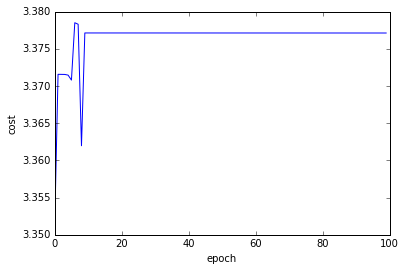

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


k2 

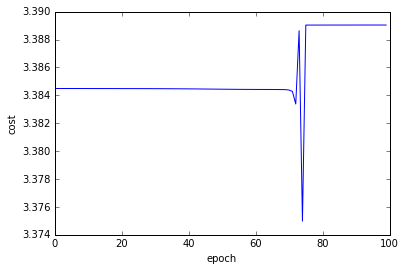

k3 

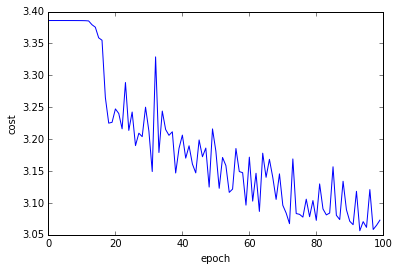

k4 

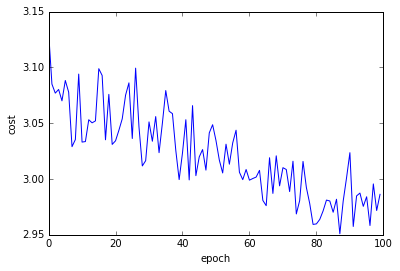

k5 

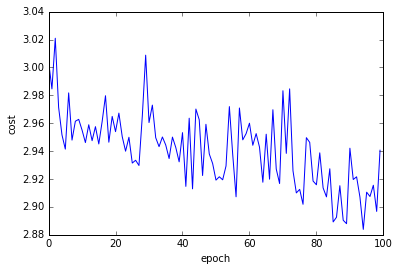


k=5 time elapsed: 0:07:51.839284
           Precision  sd      Recall sd     F1 Score sd
Training:       0.20  ± 0.15    0.20 ± 0.09     0.16 ± 0.12
Validation:     0.18  ± 0.14    0.18 ± 0.08     0.14 ± 0.10


In [8]:
# Neural Network with a single hidden layer
nn_single_hl_model = Neural_Network(input_size=len(data_X[0]), output_size=len(classes), hidden_layers=[517], learning_rate=0.01, epochs=100)
run_kfold(lambda X, Y, check_gradients: nn_single_hl_model.fit(X, Y, check_gradients), data_Y, data_X, check_gradients=True, report_timeout_seconds=120)

k1 

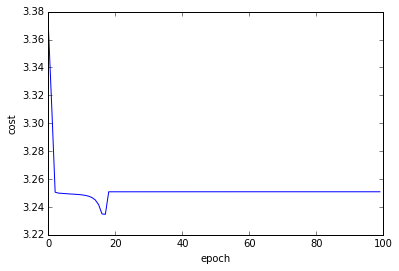

k2 

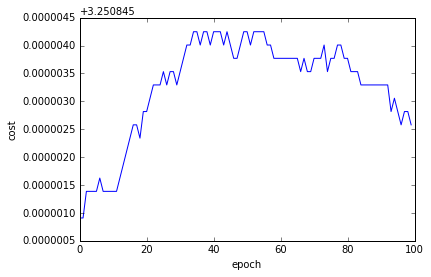

k3 

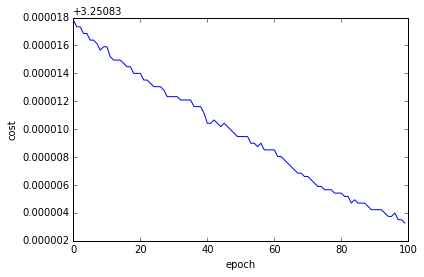


k=3 time elapsed: 0:05:56.438349
           Precision  sd      Recall sd     F1 Score sd
Training:       0.01  ± 0.00    0.10 ± 0.00     0.02 ± 0.00
Validation:     0.01  ± 0.00    0.10 ± 0.01     0.02 ± 0.00
k4 

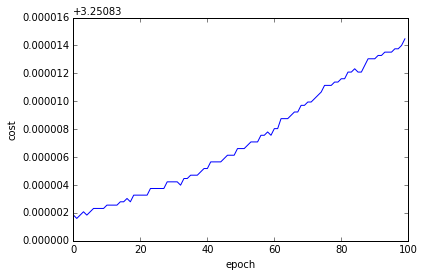


k=4 time elapsed: 0:07:58.288742
           Precision  sd      Recall sd     F1 Score sd
Training:       0.01  ± 0.00    0.10 ± 0.00     0.02 ± 0.00
Validation:     0.01  ± 0.00    0.10 ± 0.01     0.02 ± 0.00
k5 

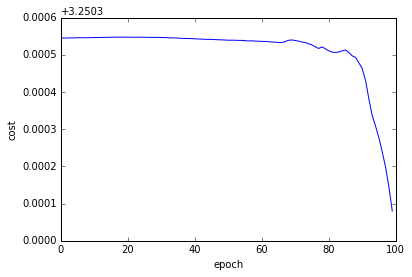


k=5 time elapsed: 0:09:56.502219
           Precision  sd      Recall sd     F1 Score sd
Training:       0.01  ± 0.00    0.10 ± 0.00     0.02 ± 0.00
Validation:     0.01  ± 0.00    0.10 ± 0.01     0.02 ± 0.00


In [9]:
# Neural Network with two hidden layers
nn_two_hl_model = Neural_Network(input_size=len(data_X[0]), output_size=len(classes), hidden_layers=[300, 300],  learning_rate=0.01, epochs=100)
run_kfold(lambda X, Y: nn_two_hl_model.fit(X, Y), data_Y, data_X, report_timeout_seconds=120)